![LogoUC3M](https://upload.wikimedia.org/wikipedia/commons/4/47/Acronimo_y_nombre_uc3m.png)

Aprendizaje Automático · Grado en Ingeniería Informática · Curso 2022/23
---
**Cuaderno** - Práctica 2: Predicción del abandono (burnout) de empleados
<br><br>
***Grupo Reducido 82 - Grupo de laboratorio 13***

# **Carga de datos**
Para comenzar, importaremos las bibliotecas que necesitamos:

+ `xgboost`: Para poder usar XGBoost en Boosting.
+ `lightgbm`: Para poder usar LightGBM en Boosting.

In [ ]:
! pip install xgboost
! pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Una vez instaladas las bibliotecas necesarias, importamos **Numpy** y **Pandas** ya que los necesitaremos para el desarrollo de la práctica.
Destacar que nos referiremos a **Numpy** como *np* y a **Pandas** como *pd* por simplicidad.

In [ ]:
import numpy as np
import pandas as pd

A continuación, cargaremos los datos necesarios. Dado que somos el **grupo 13**, usaremos los dos conjuntos de datos correspondientes.</br></br>Los datos serán divididos en un conjunto de **train** para entrenar y ajustar hiperparámetros, y un conjunto de **test** en el que evaluaremos las distintas posibilidades que se probarán en la práctica.</br></br>

In [ ]:
import pickle
from rich import print

# Datos disponibles.
with open('attrition_available_13.pkl', 'rb') as f:
    data = pickle.load(f)

df = pd.DataFrame(data)

print(df)

# Mostramos la información del conjunto de datos.
print(f"El conjunto de datos tiene {len(df)} instancias.")

hrs  absences  JobInvolvement  PerformanceRating  \
1     7.315971      13.0             2.0                4.0   
6     6.450877      17.0             3.0                4.0   
13         NaN      14.0             NaN                3.0   
28         NaN       NaN             2.0                3.0   
30    9.662808      11.0             NaN                3.0   
...        ...       ...             ...                ...   
4405  8.316921       6.0             3.0                3.0   
4406  5.897197       8.0             2.0                3.0   
4407  7.149526      18.0             3.0                NaN   
4408  9.187612       NaN             NaN                3.0   
4409  6.511790      17.0             NaN                3.0   

      EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance   Age  \
1                         3.0              2.0              NaN   NaN   
6                         1.0              3.0              1.0  28.0   
13                        NaN              2.0              2.0  47.0   
28                        NaN              3.0              1.0  44.0   
30                        1.0              2.0              3.0  26.0   
...                       ...              ...              ...   ...   
4405                      4.0              1.0              3.0  42.0   
4406                      4.0              NaN              3.0   NaN   
4407                      1.0              3.0              3.0  25.0   
4408                      4.0              1.0              3.0  42.0   
4409                      1.0              3.0              NaN  40.0   

     Attrition     BusinessTravel  ... NumCompaniesWorked  Over18  \
1          Yes  Travel_Frequently  ...                0.0       Y   
6          Yes      Travel_Rarely  ...                2.0       Y   
13         Yes         Non-Travel  ...                NaN     NaN   
28         Yes  Travel_Frequently  ...                3.0       Y   
30         Yes      Travel_Rarely  ...                2.0       Y   
...        ...                ...  ...                ...     ...   
4405        No      Travel_Rarely  ...                3.0       Y   
4406        No      Travel_Rarely  ...                2.0       Y   
4407        No      Travel_Rarely  ...                0.0     NaN   
4408        No      Travel_Rarely  ...                0.0       Y   
4409        No      Travel_Rarely  ...                0.0       Y   

      PercentSalaryHike StandardHours  StockOptionLevel  TotalWorkingYears  \
1                   NaN           8.0               1.0                6.0   
6                  20.0           8.0               1.0                5.0   
13                  NaN           8.0               2.0               10.0   
28                 14.0           8.0               1.0                NaN   
30                 11.0           8.0               NaN                5.0   
...                 ...           ...               ...                ...   
4405                NaN           8.0               1.0               10.0   
4406               15.0           8.0               0.0               10.0   
4407                NaN           8.0               0.0                5.0   
4408               14.0           8.0               1.0               10.0   
4409               12.0           8.0               0.0                NaN   

     TrainingTimesLastYear  YearsAtCompany YearsSinceLastPromotion  \
1                      3.0             5.0                       1   
6                      2.0             NaN                       0   
13                     4.0            10.0                       9   
28                     2.0             NaN                       0   
30                     5.0             3.0                       0   
...                    ...             ...                     ...   
4405                   NaN             3.0                       0   
4406                   2.0             NaN         

El conjunto de datos tiene 4410 instancias.

A continuación, separamos la **matriz de atributos** (**X**) y el **vector de la variable de respuesta** *salida* (**y**).

In [ ]:
# Datos.
X = df.drop('Attrition', axis=1)

# Etiquetas.
y = df.Attrition

print(y)

1       Yes
6       Yes
13      Yes
28      Yes
30      Yes
       ... 
4405     No
4406     No
4407     No
4408     No
4409     No
Name: Attrition, Length: 4410, dtype: object

# **Análisis Exploratorio de Datos (EDA)**
Antes de comenzar, destacar que dado que los resultados deben ser reproducibles, hemos fijado la **semilla de números aleatorios** en los lugares adecuados. Para ello, hemos seleccionado como semilla el número del grupo de prácticas (*13*).</br></br>
Para poder realizar el análisis exploratorio de datos, llevaremos a cabo los siguientes pasos:

+ Número de instancias y atributos.
+ Tipo de atributos (numéricos o categóricos).
+ Columnas constantes o innecesarias.
+ Proporción de *missing values*.
+ Tipo de problema (clasificación o regresión).
+ Desbalance.

## **Número de instancias y atributos**
Los **datos** cuentan con 30 atributos y la variable de respuesta *Attrition*. En total, contamos con un total de **4410 instancias**.</br></br>

A continuación, profundizaremos más en los atributos, su significado y nomenclatura.</br></br>

Como podemos ver en la siguiente tabla, contamos con **30 atributos** diferentes, cada uno de ellos con su respectivo nombre (identificador) y con su unidad concreta. Estos atributos corresponden con **variables sobre empleados de la empresa recopilados por el departamento de recursos humanos**. El último valor que podemos observar es la predicción de abandono de empleados (burnout) o, de otra forma, la variable de salida de nuestros datos.</br></br>

| Columna | Descripción | Tipo de dato |
| :- | :- | -: |
| `hrs` | Número de horas trabajadas. | $float64$ |
| `absences` | El número de ausencias tomadas por el empleado. | $float64$ |
| `JobInvolvement` | El nivel de compromiso que tiene el empleado con su trabajo. | $float64$ |
| `PerformanceRating` | La evaluación de desempeño del empleado. | $float64$ |
| `EnvironmentSatisfaction`	 | El nivel de satisfacción que el empleado tiene con su entorno laboral. | $float64$ |
| `JobSatisfaction`	 | El nivel de satisfacción que el empleado tiene con su trabajo. | $float64$ |
| `WorkLifeBalance`	 | El equilibrio entre la vida laboral y personal del empleado. | $float64$ |
| `Age` | La edad del empleado. | $float64$ |
| `BusinessTravel` | La frecuencia de los viajes de negocios del empleado. | $object$ |
| `Department` | El departamento en el que trabaja el empleado..	| $object$ |
| `DistanceFromHome` | La distancia desde la casa del empleado. | $float64$ |
| `Education` | El nivel más alto de educación alcanzado por el empleado. | $int64$ |
| `EducationField` | El campo de estudio en el que el empleado se especializó. | $object$ |
| `EmployeeCount` | El número de empleados en la empresa. | $float64$ |
| `EmployeeID` | Un identificador único para cada empleado. | $int64$ |
| `Gender` | El genero del empleado. | $object$ |
| `JobLevel` | El nivel de trabajo del empleado en la jerarquía de la empresa. | $float64$ |
| `JobRole` | El rol específico que el empleado tiene en su departamento. | $object$ |
| `MaritalStatus` | El estado civil del empleado. | $object$ |
| `MonthlyIncome` | El ingreso mensual del empleado. | $float64$ |
| `NumCompaniesWorked` | El número de empresas para las que el empleado ha trabajado antes de unirse a la empresa actual. | $float64$ |
| `Over18` | Si el empleado es mayor de 18 años (presumiblemente todos los empleados lo son). | $object$ |
| `PercentSalaryHike` | El porcentaje de aumento salarial que recibió el empleado en su último aumento de sueldo. | $float64$ |
| `StandardHours` | El número estándar de horas de trabajo en la empresa. | $float64$ |
| `StackOptionLevel` | El nivel de opción de compra de acciones que tiene el empleado. | $float64$ |
| `TotalWorkingYears` | El número total de años que el empleado ha trabajado. | $float64$ |
| `TrainingTimesLastYear` | El número de veces que el empleado recibió capacitación en el último año. | $float64$ |
| `YearsAtCompany` | El número de años que el empleado ha estado en la empresa. | $float64$ |
| `YearsSinceLastPromotion` | El número de años desde la última promoción del empleado. | $float64$ |
| `YearsWithCurrManager` | El número de años que el empleado ha estado con su gerente actual. | $float64$ |
| `Attrition` | Si el empleado ha dejado la empresa o no. | $object$ |


## **Tipo de atributos**

Dentro de los diferentes tipos de atributos de los datos podemos encontrar los categóricos, numéricos u ordinales.</br></br>

En el caso de nuestros datos, podemos ver como claramente como cada uno de ellos es de un tipo diferente.</br></br>

Por tanto, dado que no todos los datos con los que vamos a tratar son atributos numéricos, tendremos que transformar las variables categóricas en **one-hot-encoding** y las variables ordinales en numéricas.

In [ ]:
print(df.dtypes)

hrs                        float64
absences                   float64
JobInvolvement             float64
PerformanceRating          float64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
Age                        float64
Attrition                   object
BusinessTravel              object
Department                  object
DistanceFromHome           float64
Education                  float64
EducationField              object
EmployeeCount              float64
EmployeeID                 float64
Gender                      object
JobLevel                   float64
JobRole                     object
MaritalStatus               object
MonthlyIncome              float64
NumCompaniesWorked         float64
Over18                      object
PercentSalaryHike          float64
StandardHours              float64
StockOptionLevel           float64
TotalWorkingYears          float64
TrainingTimesLastYear      float64
YearsAtCompany             float64
YearsSinceLastPromotion      int64
YearsWithCurrManager       float64
dtype: object

## **Columnas constantes o innecesarias**

La primera observación que podemos hacer es que la columna EmployeeID es irrelevante para nuestro estudio, ya que la información que recoge no aporta nada a nuestro estudio; por tanto la eliminaremos.

Esto es debido a que una variable que indica un identificador para cada empleado no tendrá ningun tipo de relevancia para predecir el burnout.

In [ ]:
X.drop('EmployeeID', axis=1)

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
1,7.315971,13.0,2.0,4.0,3.0,2.0,NaN,NaN,Travel_Frequently,Research & Development,...,0.0,Y,NaN,8.0,1.0,6.0,3.0,5.0,1,NaN
6,6.450877,17.0,3.0,4.0,1.0,3.0,1.0,28.0,Travel_Rarely,Research & Development,...,2.0,Y,20.0,8.0,1.0,5.0,2.0,NaN,0,0.0
13,NaN,14.0,NaN,3.0,NaN,2.0,2.0,47.0,Non-Travel,Research & Development,...,NaN,NaN,NaN,8.0,2.0,10.0,4.0,10.0,9,9.0
28,NaN,NaN,2.0,3.0,NaN,3.0,1.0,44.0,Travel_Frequently,Research & Development,...,3.0,Y,14.0,8.0,1.0,NaN,2.0,NaN,0,0.0
30,9.662808,11.0,NaN,3.0,1.0,2.0,3.0,26.0,Travel_Rarely,Research & Development,...,2.0,Y,11.0,8.0,NaN,5.0,5.0,3.0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,8.316921,6.0,3.0,3.0,4.0,1.0,3.0,42.0,Travel_Rarely,Research & Development,...,3.0,Y,NaN,8.0,1.0,10.0,NaN,3.0,0,2.0
4406,5.897197,8.0,2.0,3.0,4.0,NaN,3.0,NaN,Travel_Rarely,Research & Development,...,2.0,Y,15.0,8.0,0.0,10.0,2.0,NaN,0,NaN
4407,7.149526,18.0,3.0,NaN,1.0,3.0,3.0,25.0,Travel_Rarely,Research & Development,...,0.0,NaN,NaN,8.0,0.0,5.0,4.0,4.0,1,2.0
4408,9.187612,NaN,NaN,3.0,4.0,1.0,3.0,42.0,Travel_Rarely,Sales,...,0.0,Y,14.0,8.0,1.0,10.0,2.0,NaN,7,8.0


A continuación, buscaremos que columnas son constantes o inecesarias (valores nulos) y las eliminaremos.

In [ ]:
drop_cols = []
for col in X.columns:
    if X[col].nunique() == 1:
        # la columna es constante
        print(f'Columna {col} es constante y será eliminada')
        drop_cols.append(col)

    if X[col].isna().sum() == len(data):
        # la columna tiene todos los valores nulos
        print(f'Columna {col} tiene todos los valores nulos y será eliminada')
        drop_cols.append(col)

# Eliminar las columnas constantes o innecesarias
X.drop(drop_cols, axis=1, inplace=True)

Columna EmployeeCount es constante y será eliminada

Columna Over18 es constante y será eliminada

Columna StandardHours es constante y será eliminada

Por último, usaremos el método describe() para observar la naturaleza de las columnas constantes. Observaremos los valores de la media, la desviación estándar y los percentiles para cada atributo. Si un atributo tiene una media, una desviación estándar y percentiles iguales, esto puede indicar que todos sus valores son iguales, lo que significa que la columna es constante y puede ser eliminada.

In [ ]:
X.describe()

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,DistanceFromHome,Education,...,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
count,3467.000000,3655.000000,3526.000000,3448.000000,3599.000000,3506.000000,3475.000000,3585.000000,3526.000000,3500.000000,...,3631.000000,3655.000000,3594.000000,3542.000000,3655.000000,3495.000000,3620.000000,3681.000000,4410.000000,3663.000000
mean,7.312232,12.766895,2.730856,3.156903,2.720478,2.730462,2.768921,36.969038,9.147192,2.915143,...,2.050124,65260.393981,2.693656,15.149068,0.792339,11.300715,2.795856,7.086661,2.187755,4.114387
std,1.327228,5.508400,0.707324,0.363762,1.091022,1.101715,0.701886,9.158292,8.063764,1.029404,...,1.100072,47135.959457,2.489930,3.640018,0.854074,7.853680,1.288045,6.194303,3.221699,3.534687
min,5.416880,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,18.000000,1.000000,1.000000,...,1.000000,10090.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.281109,8.000000,2.000000,3.000000,2.000000,2.000000,2.000000,30.000000,2.000000,2.000000,...,1.000000,29260.000000,1.000000,12.000000,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000
50%,7.006571,13.000000,3.000000,3.000000,3.000000,3.000000,3.000000,36.000000,7.000000,3.000000,...,2.000000,49360.000000,2.000000,14.000000,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000
75%,7.899147,17.000000,3.000000,3.000000,4.000000,4.000000,3.000000,43.000000,14.000000,4.000000,...,3.000000,83940.000000,4.000000,18.000000,1.000000,15.000000,3.000000,10.000000,3.000000,7.000000
max,10.907255,24.000000,4.000000,4.000000,4.000000,4.000000,4.000000,60.000000,29.000000,5.000000,...,5.000000,199990.000000,9.000000,25.000000,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000


En conclusión, las columnas restantes son suficientemente relevantes para permanecer en nuestros datos de estudio. Con ```X.describe()```sólo se muestran las variables numéricas, pero imprimiendo X podemos ver como hemos pasado de 30 columnas a 27, dado que hemos eliminado 3 de ellas.



In [ ]:
X

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,...,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
1,7.315971,13.0,2.0,4.0,3.0,2.0,NaN,NaN,Travel_Frequently,Research & Development,...,Single,41890.0,0.0,NaN,1.0,6.0,3.0,5.0,1,NaN
6,6.450877,17.0,3.0,4.0,1.0,3.0,1.0,28.0,Travel_Rarely,Research & Development,...,Single,58130.0,2.0,20.0,1.0,5.0,2.0,NaN,0,0.0
13,NaN,14.0,NaN,3.0,NaN,2.0,2.0,47.0,Non-Travel,Research & Development,...,Married,57620.0,NaN,NaN,2.0,10.0,4.0,10.0,9,9.0
28,NaN,NaN,2.0,3.0,NaN,3.0,1.0,44.0,Travel_Frequently,Research & Development,...,Divorced,103330.0,3.0,14.0,1.0,NaN,2.0,NaN,0,0.0
30,9.662808,11.0,NaN,3.0,1.0,2.0,3.0,26.0,Travel_Rarely,Research & Development,...,NaN,68540.0,2.0,11.0,NaN,5.0,5.0,3.0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,8.316921,6.0,3.0,3.0,4.0,1.0,3.0,42.0,Travel_Rarely,Research & Development,...,Single,60290.0,3.0,NaN,1.0,10.0,NaN,3.0,0,2.0
4406,5.897197,8.0,2.0,3.0,4.0,NaN,3.0,NaN,Travel_Rarely,Research & Development,...,NaN,NaN,2.0,15.0,0.0,10.0,2.0,NaN,0,NaN
4407,7.149526,18.0,3.0,NaN,1.0,3.0,3.0,25.0,Travel_Rarely,Research & Development,...,Married,37020.0,0.0,NaN,0.0,5.0,4.0,4.0,1,2.0
4408,9.187612,NaN,NaN,3.0,4.0,1.0,3.0,42.0,Travel_Rarely,Sales,...,Divorced,NaN,0.0,14.0,1.0,10.0,2.0,NaN,7,8.0


## **Proporción de missing values**

A continuación, comprobaremos los **missings values** que existen en nuestros datos. Para ello, tomaremos el dataframe de datos creado anteriormente y haremos una suma por atributo de los missing values y lo compararemos con el número total de valores. Tras esto, crearemos una tabla para poder ver de manera clara las proporciones de missing values de cada atributo.

In [ ]:
# Función que cuenta el número de missing values por atributos,
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_percent_rounded = mis_val_percent.round(2).astype(str) + '%'
    mis_val_table = pd.concat([mis_val, mis_val_percent_rounded], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : 'Proporción'})
    return mis_val_table_ren_columns
  
# Generamos las proporciones de missing values.
missing_values_table(df)

,Missing Values,Proporción
hrs,943,21.38%
absences,755,17.12%
JobInvolvement,884,20.05%
PerformanceRating,962,21.81%
EnvironmentSatisfaction,811,18.39%
JobSatisfaction,904,20.5%
WorkLifeBalance,935,21.2%
Age,825,18.71%
Attrition,0,0.0%
BusinessTravel,852,19.32%


De la tabla anterior podemos ver como claramente existe una alta cantidad de missing values en la mayoría de atributos, aunque hay algunos de ellos que no cuentan con ninguno. En general, oscilan entre un 15% y un 20% de valores nulos.

## **Tipo de problema**

Según la descripción del enunciado del proyecto, el problema se trata de predecir si es probable que los empleados abandonen la empresa, por lo que estamos ante un problema de **clasificación binaria**, donde la variable objetivo '**Attrrition**' es una etiqueta binaria que indica si un empleado abandonará la empresa (**Yes**) o no (**No**).

In [ ]:
y.describe()


count     4410
unique       2
top         No
freq      3699
Name: Attrition, dtype: object

## **Desbalance**
Para comprobar si es un problema desbalanceado, vamos a comprobar las proporciones de la varibale de salida para comprobar si hay una clase mayoritaría

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

np.random.seed(13)

# Realizamos una división train/test "normal".
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2/10, random_state=13, shuffle=True)

# Codificamos las etiquetas de las clases
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

N_SAMPLES_NEG = np.sum(y_encoded == 0)
N_SAMPLES_POS = np.sum(y_encoded == 1)

# Ahora comprobamos la distribución de las clases.
n_pos_pct = N_SAMPLES_POS / (N_SAMPLES_POS + N_SAMPLES_NEG)
n_pos_train_pct = np.sum(y_train) / len(y_train)
n_pos_test_pct = np.sum(y_test) / len(y_test)

print(f"Hay un {100 * n_pos_train_pct:.1f} % de instancias positivas en train.")
print(f"Hay un {100 * n_pos_test_pct:.1f} % de instancias positivas en test.")
print(f"Hay un {100 * n_pos_pct:.1f} % de instancias positivas en total.")

Hay un 15.6 % de instancias positivas en train.

Hay un 18.3 % de instancias positivas en test.

Hay un 16.1 % de instancias positivas en total.

De los resultados obtenidos, se puede concluir que el problema de aprendizaje automático podría considerarse desbalanceado, ya que la proporción de instancias positivas es menor que la proporción de instancias negativas en los conjuntos de datos de entrenamiento, prueba y total.

En particular, la proporción de instancias positivas en el conjunto de entrenamiento y en el conjunto total es del 15.6%, mientras que la proporción de instancias positivas en el conjunto de prueba es del 18.3%.

Debido a que nuestro problema es desbalanceado, tendremos que usar particiones estratificadas y métricas adecuadas como balanced_accuracy, f1 o matriz de confusión.

In [ ]:
# Ahora realizaremos una división train/test estratificada.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2/10, random_state=13, shuffle=True, stratify=y)

# Codificamos las etiquetas de las clases
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_train = le.fit_transform(y_train)
y_test= le.transform(y_test)

N_SAMPLES_NEG = np.sum(y_encoded == 0)
N_SAMPLES_POS = np.sum(y_encoded == 1)

# Ahora comprobamos la distribución de las clases.
n_pos_pct = N_SAMPLES_POS / (N_SAMPLES_POS + N_SAMPLES_NEG)
n_pos_train_pct = np.sum(y_train) / len(y_train)
n_pos_test_pct = np.sum(y_test) / len(y_test)

print(f"Hay un {100 * n_pos_train_pct:.1f} % de instancias positivas en train.")
print(f"Hay un {100 * n_pos_test_pct:.1f} % de instancias positivas en test.")
print(f"Hay un {100 * n_pos_pct:.1f} % de instancias positivas en total.")

Hay un 16.1 % de instancias positivas en train.

Hay un 16.1 % de instancias positivas en test.

Hay un 16.1 % de instancias positivas en total.

Como podemos ver, hemos realizado una división train/test estratificada, lo que asegura que la proporción de instancias positivas y negativas se mantenga tanto en el conjunto de entrenamiento como en el conjunto de prueba. Además, al calcular la distribución de las clases en los conjuntos de entrenamiento y prueba, se observa que ambos tienen una proporción del 16.1% de instancias positivas, lo que indica que el problema está equilibrado en cuanto a la distribución de clases y no hay un desbalance de clases significativo.

# **Construcción de modelos**

## **División de datos**

In [ ]:
X_train      

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,...,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
2342,5.981773,17.0,NaN,3.0,2.0,3.0,2.0,35.0,NaN,Sales,...,Married,NaN,1.0,12.0,1.0,NaN,4.0,10.0,6,8.0
2963,NaN,22.0,1.0,3.0,2.0,3.0,3.0,42.0,Travel_Rarely,Research & Development,...,Married,89260.0,NaN,14.0,0.0,20.0,4.0,20.0,11,6.0
1254,7.507934,6.0,NaN,3.0,1.0,3.0,NaN,26.0,Travel_Rarely,Sales,...,Single,24040.0,NaN,NaN,0.0,1.0,6.0,1.0,0,1.0
704,9.102632,11.0,NaN,3.0,3.0,2.0,3.0,51.0,Travel_Rarely,Sales,...,NaN,NaN,1.0,13.0,1.0,33.0,NaN,33.0,0,10.0
384,6.622714,NaN,4.0,3.0,2.0,2.0,3.0,38.0,Travel_Rarely,Sales,...,Married,137340.0,0.0,13.0,0.0,3.0,3.0,2.0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928,7.774158,19.0,2.0,NaN,4.0,NaN,4.0,35.0,NaN,Research & Development,...,NaN,NaN,3.0,11.0,1.0,13.0,NaN,11.0,6,7.0
183,NaN,13.0,NaN,NaN,2.0,3.0,3.0,42.0,Travel_Frequently,Research & Development,...,Married,29770.0,4.0,15.0,NaN,8.0,3.0,NaN,2,NaN
2484,6.003905,15.0,2.0,NaN,4.0,3.0,3.0,38.0,Travel_Rarely,Research & Development,...,Married,NaN,1.0,11.0,1.0,5.0,NaN,5.0,0,NaN
462,9.914448,14.0,2.0,3.0,1.0,3.0,NaN,30.0,Travel_Rarely,Sales,...,Married,40000.0,4.0,12.0,0.0,NaN,5.0,5.0,0,1.0


## **Preprocesamiento de los datos**
A continuación llevaremos a cabo el **procesamiento** de los datos mediante pipelines. Para ello, obtendremos las variables numéricas y las variables categóricas. Tras esto, haremos una operación distinta para cada una de ellas:
+ **Variables numéricas**: Sustituiremos los missing values con la **media** de los valores de esa columna.
+ **Variables categóricas**: Sustituiremos los missing values con la **moda** de los valores de esa columna. Además, codificaremos usando one-hot encoding para tener datos numéricos para el resto del análisis.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Obtenemos los nombres de las columnas que tienen tipo de dato 'object' o 'category'.
cols_categoricas = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Obtenemos los nombres de las columnas que tienen tipo de dato 'int' o 'float'.
cols_numericas = X.select_dtypes(include=['int', 'float']).columns.tolist()

print("Columnas categóricas: ", cols_categoricas)
print("Columnas numéricas: ", cols_numericas)

# Procesamos valores numéricos.
imputer_num = SimpleImputer(strategy='mean')
pipeline_num = Pipeline(
    steps=[
        ("imputer", imputer_num)
    ]
)

# Procesamos valores categóricos (imputamos con la moda y luego codificamos con one-hot encoding).
imputer_cat = SimpleImputer(strategy='most_frequent')
encoder_cat = OneHotEncoder()
pipeline_cat = Pipeline(
    steps=[
        ("imputer", imputer_cat),
        ("onehot", encoder_cat)
    ]
)

# Pre-procesador "global".
# Dependiendo del tipo de columna aplicamos una transformación u otra.
processor = ColumnTransformer(
    transformers=[
        ("num", pipeline_num, cols_numericas),
        ("cat", pipeline_cat, cols_categoricas),
    ]
)

# Realizamos la transformación.
X_train = processor.fit_transform(X_train)
X_test = processor.transform(X_test)

# Convertimos el resultado a un DataFrame de Pandas con los nombres de las columnas correctos.
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train
X_test

Columnas categóricas: 
['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']

Columnas numéricas: 
[
    'hrs',
    'absences',
    'JobInvolvement',
    'PerformanceRating',
    'EnvironmentSatisfaction',
    'JobSatisfaction',
    'WorkLifeBalance',
    'Age',
    'DistanceFromHome',
    'Education',
    'EmployeeID',
    'JobLevel',
    'MonthlyIncome',
    'NumCompaniesWorked',
    'PercentSalaryHike',
    'StockOptionLevel',
    'TotalWorkingYears',
    'TrainingTimesLastYear',
    'YearsAtCompany',
    'YearsSinceLastPromotion',
    'YearsWithCurrManager'
]

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,6.684089,8.000000,2.73402,4.00000,1.000000,4.000000,3.0,38.0,23.000000,3.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,8.110050,16.000000,4.00000,3.00000,4.000000,1.000000,3.0,37.0,7.000000,2.917681,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,7.290853,17.000000,3.00000,3.00000,2.714832,2.744211,3.0,41.0,6.000000,2.917681,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,10.706489,6.000000,3.00000,3.00000,4.000000,1.000000,3.0,46.0,12.000000,3.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,7.296914,7.000000,2.00000,3.16102,1.000000,2.744211,3.0,43.0,1.000000,3.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,7.206898,12.000000,3.00000,3.00000,3.000000,3.000000,3.0,54.0,9.233061,3.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
878,7.296914,12.739338,3.00000,3.00000,3.000000,2.744211,4.0,34.0,9.233061,3.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
879,7.296914,12.739338,2.73402,3.00000,1.000000,2.744211,3.0,36.0,28.000000,1.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
880,5.852395,12.739338,3.00000,3.00000,4.000000,4.000000,3.0,42.0,8.000000,2.917681,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Obtener los nombres de las nuevas columnas generadas por el OneHotEncoder
new_col_names = processor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cols_categoricas)

# Obtener el número de columnas generadas para cada columna original
n_cols_generated = processor.named_transformers_['cat'].named_steps['onehot'].categories_
n_cols_generated = list(map(len, n_cols_generated))



# Crear una lista de tuplas con el nombre de la columna original y las nuevas columnas generadas
cols_transformed = []
for i, col in enumerate(cols_categoricas):
  cols_transformed.extend([(col, new_col_names[j]) for j in range(int(sum(n_cols_generated[:i])), int(sum(n_cols_generated[:i+1])))])

print(cols_transformed)

[
    ('BusinessTravel', 'BusinessTravel_Non-Travel'),
    ('BusinessTravel', 'BusinessTravel_Travel_Frequently'),
    ('BusinessTravel', 'BusinessTravel_Travel_Rarely'),
    ('Department', 'Department_Human Resources'),
    ('Department', 'Department_Research & Development'),
    ('Department', 'Department_Sales'),
    ('EducationField', 'EducationField_Human Resources'),
    ('EducationField', 'EducationField_Life Sciences'),
    ('EducationField', 'EducationField_Marketing'),
    ('EducationField', 'EducationField_Medical'),
    ('EducationField', 'EducationField_Other'),
    ('EducationField', 'EducationField_Technical Degree'),
    ('Gender', 'Gender_Female'),
    ('Gender', 'Gender_Male'),
    ('JobRole', 'JobRole_Healthcare Representative'),
    ('JobRole', 'JobRole_Human Resources'),
    ('JobRole', 'JobRole_Laboratory Technician'),
    ('JobRole', 'JobRole_Manager'),
    ('JobRole', 'JobRole_Manufacturing Director'),
    ('JobRole', 'JobRole_Research Director'),
    ('JobRole', 'JobRole_Research Scientist'),
    ('JobRole', 'JobRole_Sales Executive'),
    ('JobRole', 'JobRole_Sales Representative'),
    ('MaritalStatus', 'MaritalStatus_Divorced'),
    ('MaritalStatus', 'MaritalStatus_Married'),
    ('MaritalStatus', 'MaritalStatus_Single')
]

Esta lista la usaremos posteriormente para mapear los indices de los atributos más importantes en la última sección.

## **Dummy models**

In [ ]:
from sklearn.dummy import DummyClassifier
import time

# Crear un clasificador dummy que prediga siempre la clase mayoritaria
dummy = DummyClassifier(strategy='most_frequent')

# Entrenar el clasificador
start = time.time()
dummy.fit(X_train, y_train)
end = time.time()
tiempo_dummy = end - start

# Predecir valores para el conjunto de test
y_pred = dummy.predict(X_test)

# Usaremos las métricas balanced_accuracy_score, f1 y matríz de confusión.
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix

# Calculamos las métricas.
balanced_accuracy_dummy = balanced_accuracy_score(y_test, y_pred)
f1_dummy = f1_score(y_test, y_pred)
confusion_matrix_dummy = confusion_matrix(y_test, y_pred)

print('\n[bold yellow]Dummy classifier (most frequent class)[/bold yellow]')
print(f'Tiempo de entrenamiento: {tiempo_dummy:.4f} segundos')
print(f'Balanced accuracy: {balanced_accuracy_dummy:.4f}')
print(f'F1: {f1_dummy:.4f}')
print(f'Confusion matrix:\n{confusion_matrix_dummy}')

Dummy classifier (most frequent class)

Tiempo de entrenamiento: 0.0010 segundos

Balanced accuracy: 0.5000

F1: 0.0000

Confusion matrix:
[[740   0]
 [142   0]]

## **LogisticRegression**
Para comenzar, usaremos **LogisticRegression** como método base sin realizar ajuste de hiper-parámetros.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Creamos el modelo.
model = LogisticRegression(random_state=13, solver='liblinear', class_weight='balanced')

# Lo entrenamos.
start = time.time()
model.fit(X_train, y_train)
end = time.time()
tiempo = end - start

# Predecimos sobre el conjunto de test.
y_pred = model.predict(X_test)

# Calculamos las métricas.
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print('\n[bold yellow]Logistic regression[/bold yellow]')
print(f'Tiempo de entrenamiento: {tiempo:.4f} segundos.')
print(f'Balanced accuracy: {balanced_accuracy:.4f}')
print(f'F1: {f1:.4f}')
print(f'Confusion matrix:\n{conf_matrix}')

Logistic regression

Tiempo de entrenamiento: 0.0863 segundos.

Balanced accuracy: 0.7266

F1: 0.4654

Confusion matrix:
[[549 191]
 [ 41 101]]

Las métricas de evaluación usadas y sus resultados son:

+ **Balanced accuracy**: Es una métrica que toma en cuenta el desbalanceo de las clases en la variable de salida. En este caso, el valor obtenido es de 0.5000, lo que significa que el modelo no ha logrado aprender a distinguir entre las clases de manera efectiva.

+ **F1-score**: Es una medida que combina la precisión y el recall (sensibilidad) de la clasificación binaria. En este caso, el valor obtenido es de 0.0000, lo que indica que el modelo no ha logrado identificar correctamente ninguna de las observaciones de la clase positiva.

+ **Confusion matrix**: Es una matriz de 2x2 que resume las predicciones del modelo en términos de verdaderos positivos (TP), verdaderos negativos (TN), falsos positivos (FP) y falsos negativos (FN). En este caso, el modelo ha clasificado correctamente todos los casos de la clase negativa (TN=740), pero no ha logrado identificar correctamente ninguno de los casos de la clase positiva (TP=0, FN=142).

A continuación, analizaremos la mejora entre LogisticRegression sin ajuste de hiper-parámetros y el modelo dummy creado anteriormente.

In [ ]:
# Speedup de LogisticRegression vs DummyClassifier.
print('\n[bold yellow]Ratios entre LogisticRegression y DummyClassifier[/bold yellow]')
print(f'Ratio Tiempo de entrenamiento LogisticRegression / dummy: {tiempo / tiempo_dummy:.4f}')
print(f'Ratio Balanced accuracy LogisticRegression / dummy: {balanced_accuracy / balanced_accuracy_dummy:.4f}')


Ratios entre LogisticRegression y DummyClassifier

Ratio Tiempo de entrenamiento LogisticRegression / dummy: 88.2401

Ratio Balanced accuracy LogisticRegression / dummy: 1.4532

En estos resultados, se observa que el modelo de regresión logística tiene un tiempo de entrenamiento casi 100 veces mayor que el modelo dummy, lo que puede indicar un mayor costo computacional. Sin embargo, la métrica de precisión balanceada indica que la regresión logística supera ampliamente al modelo dummy, con un ratio de 1.4532 veces mejor. En general, se podría concluir que el modelo de regresión logística es una opción más eficiente y precisa que el modelo dummy en este caso.

## **Boosting**

## **Alternativa para class_weight='balanced'**

Necesitamos estas dos alternativas para poder lidiar con el desbalanceo de datos en los métodos AdaBoost y Gradient Boosting.

In [ ]:
# calcular los pesos de muestra personalizados para el conjunto de entrenamiento
class_counts = np.bincount(y_train)
sample_weights = np.zeros(len(y_train))
for i, count in enumerate(class_counts):
    sample_weights[y_train == i] = class_counts.sum() / (len(class_counts) * count)

# Calcular los pesos de las muestras
weights = np.where(y_train == 0, 1 / np.sum(y_train == 0), 1 / np.sum(y_train == 1))

#Calcular la proporción de la clase mayoritaria
proporcion = np.sum(y_train == 0) / np.sum(y_train == 1)

### **Boosting sin ajuste de hiper-parámetros**

In [ ]:
# Importamos todas las implementaciones de boosting que vamos a probar.
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

# Librerias externas (extra).
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Importamos time.
import time

# Creamos un diccionario con los modelos que vamos a evaluar.
modelos = {
    'AdaBoost': AdaBoostClassifier(random_state=13),
    'Gradient Boosting': GradientBoostingClassifier(random_state=13),
    'XGBoost': XGBClassifier(random_state=13, scale_pos_weight=proporcion),
    'LightGBM': LGBMClassifier(random_state=13, class_weight='balanced'),
}


# Creamos una función para evaluar los modelos.
def evaluar_modelos(models, X_train, y_train, X_test, y_test):
    # Creamos un diccionario para guardar los resultados.
    resultados = {}

    # Iteramos sobre los modelos.
    for nombre_modelo, modelo in models.items():
        #print(f'Evaluando modelo: {nombre_modelo}')

        # Entrenamos el modelo.
        if nombre_modelo == 'AdaBoost':
            start = time.time()
            modelo.fit(X_train, y_train, sample_weight=sample_weights)
            end = time.time()
        elif nombre_modelo == 'Gradient Boosting':
            start = time.time()
            modelo.fit(X_train, y_train, sample_weight=weights)
            end = time.time()
        else:
            start = time.time()
            modelo.fit(X_train, y_train)
            end = time.time()

        tiempo = end - start

        # Predecimos sobre el conjunto de test.
        y_pred = modelo.predict(X_test)

        # Calculamos las métricas.
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Guardamos los resultados.
        resultados[nombre_modelo] = {
            'tiempo': tiempo,
            'model': modelo,
            'balanced_accuracy': balanced_accuracy,
            'f1': f1,
            'confusion_matrix': conf_matrix
        }

    return resultados# calcular los pesos de muestra personalizados para el conjunto de entrenamiento
class_counts = np.bincount(y_train)
sample_weights = np.zeros(len(y_train))
for i, count in enumerate(class_counts):
    sample_weights[y_train == i] = class_counts.sum() / (len(class_counts) * count)

# Calcular los pesos de las muestras
weights = np.where(y_train == 0, 1 / np.sum(y_train == 0), 1 / np.sum(y_train == 1))

print('\n[bold yellow]Boosting sin ajuste de hiper-parámetros[/bold yellow]')

# Evaluamos los modelos.
resultados = evaluar_modelos(modelos, X_train, y_train, X_test, y_test)

# Mostramos los resultados.
for nombre_modelo, resultado in resultados.items():
    print(f'[blue]Modelo: {nombre_modelo}[/blue]')
    print(f'Tiempo de ejecución: {resultado["tiempo"]:.5f} segundos')
    print(f'Balanced accuracy: {resultado["balanced_accuracy"]:.4f}')
    print(f'F1: {resultado["f1"]:.4f}')
    print(f'Confusion matrix:\n{resultado["confusion_matrix"]}\n')

Boosting sin ajuste de hiper-parámetros

Modelo: AdaBoost

Tiempo de ejecución: 0.53962 segundos

Balanced accuracy: 0.7440

F1: 0.4975

Confusion matrix:
[[580 160]
 [ 42 100]]

Modelo: Gradient Boosting

Tiempo de ejecución: 1.12091 segundos

Balanced accuracy: 0.8006

F1: 0.5870

Confusion matrix:
[[622 118]
 [ 34 108]]

Modelo: XGBoost

Tiempo de ejecución: 1.00952 segundos

Balanced accuracy: 0.8756

F1: 0.8405

Confusion matrix:
[[733   7]
 [ 34 108]]

Modelo: LightGBM

Tiempo de ejecución: 0.18909 segundos

Balanced accuracy: 0.8719

F1: 0.7900

Confusion matrix:
[[712  28]
 [ 31 111]]

In [ ]:
# Speedup del modelo vs dummy.
for nombre_modelo, resultado in resultados.items():
    print(f'\nRatio Tiempo de entrenamiento {nombre_modelo} / dummy: {resultado["tiempo"] / tiempo_dummy:.4f}')
    print(f'Ratio Balanced accuracy {nombre_modelo} / dummy: {resultado["balanced_accuracy"] / balanced_accuracy_dummy:.4f}\n')
    

Ratio Tiempo de entrenamiento AdaBoost / dummy: 551.7647

Ratio Balanced accuracy AdaBoost / dummy: 1.4880

Ratio Tiempo de entrenamiento Gradient Boosting / dummy: 1146.1294

Ratio Balanced accuracy Gradient Boosting / dummy: 1.6011

Ratio Tiempo de entrenamiento XGBoost / dummy: 1032.2404

Ratio Balanced accuracy XGBoost / dummy: 1.7511

Ratio Tiempo de entrenamiento LightGBM / dummy: 193.3491

Ratio Balanced accuracy LightGBM / dummy: 1.7439

En estos resultados podemos ver que todos los modelos tienen un ratio de tiempo de entrenamiento significativamente mayor que el modelo DummyClassifier, lo que indica que todos estos modelos son más costosos en términos de tiempo computacional. Sin embargo, también podemos ver que todos los modelos tienen un ratio de Balanced accuracy significativamente mayor que el DummyClassifier, lo que indica que todos estos modelos son capaces de obtener mejores resultados que el modelo base.

En cuanto a la comparación entre los modelos, podemos ver que Gradient Boosting y XGBoost tienen los ratios de Balanced accuracy más altos, lo que indica que estos modelos tienen un mejor rendimiento en términos de clasificación. Sin embargo, también podemos ver que XGBoost tiene el ratio de tiempo de entrenamiento más alto, lo que indica que es el modelo más costoso en términos de tiempo computacional. Por otro lado, LightGBM tiene un ratio de tiempo de entrenamiento más bajo que los otros modelos, pero su ratio de Balanced accuracy es un poco más bajo que el de Gradient Boosting y XGBoost.

En general, estos resultados sugieren que si se busca un modelo con un alto rendimiento en términos de clasificación, Gradient Boosting y XGBoost podrían ser buenas opciones, pero si se busca un modelo que sea menos costoso en términos de tiempo computacional, LightGBM podría ser una mejor opción.

### **Boosting con ajuste de hiper-parámetros**

In [ ]:
# Importamos la clase StratifiedKFold para realizar validación cruzada estratificada.
from sklearn.model_selection import StratifiedKFold

# Importamos GridSearchCV para realizar búsqueda de hiper-parámetros.
from sklearn.model_selection import GridSearchCV

# StandardScaler para escalar los datos.
from sklearn.preprocessing import StandardScaler

cv = StratifiedKFold(n_splits=5)

# Creamos un diccionario con los parámetros que vamos a probar.
parametros = {
    'AdaBoost': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.1, 0.5, 1.0],
    },
    'Gradient Boosting': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.1, 0.5, 1.0],
        'model__max_depth': [3, 5, 7],
    },
    'XGBoost': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.1, 0.5, 1.0],
        'model__max_depth': [3, 5, 7],
    },
    'LightGBM': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.1, 0.5, 1.0],
        'model__max_depth': [3, 5, 7],
    }
}

modelos_ajustados = {}

# Creamos una función para evaluar y ajustar los modelos.
def ajustar_evaluar_modelos(modelos, parametros, X_train, y_train, X_test, y_test, cv):
    # Creamos un diccionario para guardar los resultados.
    resultados = {}

    # Iteramos sobre los modelos.
    for nombre_modelo, modelo in modelos.items():
        #print(f'Evaluando modelo: {nombre_modelo}')

        # Definimos el pipeline.
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', modelo)
        ])

        # Definimos la búsqueda por grid search con validación cruzada.
        grid = GridSearchCV(
            pipeline,
            parametros[nombre_modelo],
            cv=cv,
            scoring='balanced_accuracy',
            n_jobs=-1,
            verbose=1
        )

        # Entrenamos el modelo.
        if nombre_modelo == 'AdaBoost':
            start = time.time()
            grid.fit(X_train, y_train, model__sample_weight=sample_weights)
            end = time.time()
        elif nombre_modelo == 'Gradient Boosting':
            start = time.time()
            grid.fit(X_train, y_train, model__sample_weight=weights)
            end = time.time()
        else:
            start = time.time()
            grid.fit(X_train, y_train)
            end = time.time()

        tiempo = end - start     

        # Predecimos sobre el conjunto de test.
        y_pred = grid.predict(X_test)

        # Calculamos las métricas.
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Guardamos los resultados.
        resultados[nombre_modelo] = {
            'tiempo': tiempo,
            'model': grid.best_estimator_,
            'best_params': grid.best_params_,
            'balanced_accuracy': balanced_accuracy,
            'f1': f1,
            'confusion_matrix': conf_matrix
        }

    return resultados


print('\n[bold yellow]Boosting con ajuste de hiper-parámetros[/bold yellow]')

# Evaluamos los modelos con ajuste de hiperparámetros.
resultados_ajuste = ajustar_evaluar_modelos(modelos, parametros, X_train, y_train, X_test, y_test, cv)

# Mostramos los resultados.
for nombre_modelo, resultado in resultados_ajuste.items():
    print(f'[blue]Modelo: {nombre_modelo}[/blue]')
    print(f'Parámetros: {resultado["best_params"]}')
    print(f'Tiempo de ejecución: {resultado["tiempo"]:.5f} segundos')
    print(f'Balanced accuracy: {resultado["balanced_accuracy"]:.4f}')
    print(f'F1: {resultado["f1"]:.4f}')
    print(f'Confusion matrix:\n{resultado["confusion_matrix"]}\n')

Boosting con ajuste de hiper-parámetros

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


Modelo: AdaBoost

Parámetros: {'model__learning_rate': 0.5, 'model__n_estimators': 200}

Tiempo de ejecución: 27.89228 segundos

Balanced accuracy: 0.7501

F1: 0.5089

Confusion matrix:
[[589 151]
 [ 42 100]]

Modelo: Gradient Boosting

Parámetros: {'model__learning_rate': 0.5, 'model__max_depth': 5, 'model__n_estimators': 200}

Tiempo de ejecución: 193.70659 segundos

Balanced accuracy: 0.9052

F1: 0.8699

Confusion matrix:
[[730  10]
 [ 25 117]]

Modelo: XGBoost

Parámetros: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}

Tiempo de ejecución: 102.86112 segundos

Balanced accuracy: 0.8748

F1: 0.7915

Confusion matrix:
[[711  29]
 [ 30 112]]

Modelo: LightGBM

Parámetros: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200}

Tiempo de ejecución: 19.23025 segundos

Balanced accuracy: 0.8827

F1: 0.8377

Confusion matrix:
[[728  12]
 [ 31 111]]

In [ ]:
# Speedup del modelo vs dummy.
for nombre_modelo, resultado in resultados_ajuste.items():
    print(f'\nRatio Tiempo de entrenamiento {nombre_modelo} / dummy: {resultado["tiempo"] / tiempo_dummy:.4f}')
    print(f'Ratio Balanced accuracy {nombre_modelo} / dummy: {resultado["balanced_accuracy"] / balanced_accuracy_dummy:.4f}\n')

Ratio Tiempo de entrenamiento AdaBoost / dummy: 28519.9210

Ratio Balanced accuracy AdaBoost / dummy: 1.5002

Ratio Tiempo de entrenamiento Gradient Boosting / dummy: 198065.4120

Ratio Balanced accuracy Gradient Boosting / dummy: 1.8104

Ratio Tiempo de entrenamiento XGBoost / dummy: 105175.7209

Ratio Balanced accuracy XGBoost / dummy: 1.7495

Ratio Tiempo de entrenamiento LightGBM / dummy: 19662.9722

Ratio Balanced accuracy LightGBM / dummy: 1.7655

En base a los resultados obtenidos, se observa que el tiempo de entrenamiento de estos modelos es significativamente mayor que el del modelo DummyClassifier. En términos de precisión equilibrada, Gradient Boosting y LightGBM superan a los demás modelos, pero a costa de un tiempo de entrenamiento mucho mayor. Si se considera el tiempo de entrenamiento como una limitación importante, entonces AdaBoost y XGBoost son las mejores opciones.

Por ejemplo, en el caso de Ratio Tiempo de entrenamiento AdaBoost / dummy: 28519.9210 y Ratio Balanced accuracy AdaBoost / dummy: 1.5002, AdaBoost tarda más de 28 mil veces más en entrenarse que el modelo DummyClassifier, pero logra una mejora del 150% en la precisión equilibrada. Es importante tener en cuenta que los resultados pueden variar dependiendo de los datos y el problema específico en cuestión.


En términos de precisión, el modelo que obtuvo el mejor desempeño fue Gradient Boosting, con un ratio Balanced accuracy dummy / Gradient Boosting de 1.6011 en el primer escenario y 1.8104 en el segundo. Además, en el segundo escenario, Gradient Boosting fue el modelo más rápido en términos de tiempo de entrenamiento en relación al modelo DummyClassifier.

In [ ]:
# Speedup del modelo ajustado y sin ajustar.
for nombre_modelo, resultado in resultados_ajuste.items():
    print(f'\nRatio Tiempo de entrenamiento {nombre_modelo} / {nombre_modelo} sin ajustar: {resultado["tiempo"] / resultados[nombre_modelo]["tiempo"]:.4f}')
    print(f'Ratio Balanced accuracy {nombre_modelo} / {nombre_modelo} sin ajustar: {resultado["balanced_accuracy"] / resultados[nombre_modelo]["balanced_accuracy"]:.4f}')
    print(f'Ratio F1 {nombre_modelo} / {nombre_modelo} sin ajustar: {resultado["f1"] / resultados[nombre_modelo]["f1"]:.4f}\n')

Ratio Tiempo de entrenamiento AdaBoost / AdaBoost sin ajustar: 51.6886

Ratio Balanced accuracy AdaBoost / AdaBoost sin ajustar: 1.0082

Ratio F1 AdaBoost / AdaBoost sin ajustar: 1.0229

Ratio Tiempo de entrenamiento Gradient Boosting / Gradient Boosting sin ajustar: 172.8124

Ratio Balanced accuracy Gradient Boosting / Gradient Boosting sin ajustar: 1.1307

Ratio F1 Gradient Boosting / Gradient Boosting sin ajustar: 1.4820

Ratio Tiempo de entrenamiento XGBoost / XGBoost sin ajustar: 101.8907

Ratio Balanced accuracy XGBoost / XGBoost sin ajustar: 0.9991

Ratio F1 XGBoost / XGBoost sin ajustar: 0.9418

Ratio Tiempo de entrenamiento LightGBM / LightGBM sin ajustar: 101.6967

Ratio Balanced accuracy LightGBM / LightGBM sin ajustar: 1.0124

Ratio F1 LightGBM / LightGBM sin ajustar: 1.0604

Podemos obervar que pese a que los tiempos de entrenamiento son altos, el ajuste reulta beneficioso para la mayoría de modelos en cuanto a precisión; siendo XGBoost el único que empeoraligeramente (lo cual se debe deber a que los parametros por omisión son mejores y no estan incluidos en el rango que estamos observando). AdaBoost y LightGBM mejora entre un 1-2% par ambas métricas, por lo que podriamos no considerar no recomendable ajustar estos modelos y usar los parametros por omisión. Es evidente que el número de estimadores es crucial en los modelos, lo cual tiene sentido, pero decidimos no seguir aumentando este número ya que a más numero de estrimadores mayores tiempos obtendremos (y mayores gatos de recursos).

Por último, el modelo más preciso es Gradient Boosting, aunque requiere un tiempo significativo tanto para su ajuste y su entrenamiento. Por tanto, si buscamos el método más preciso escogeríamos Gradient Boosting, pero si buscamos una mezcla de precisión y rendimiento escogeríamos LightGBM.

In [ ]:
modelos_ajustados=[AdaBoostClassifier(random_state=13, learning_rate=0.5, n_estimators=200),
                   GradientBoostingClassifier(random_state=13, learning_rate=0.5, max_depth=5, n_estimators=200),
                    XGBClassifier(random_state=13, scale_pos_weight=proporcion),
                    LGBMClassifier(random_state=13, learning_rate=0.1, max_depth=7, n_estimators=200, class_weight='balanced')
                  ]

# **Mejora de resultados**

## **LogisticRegression**

Mejora de resultados LogisticRegression

Fitting 5 folds for each of 45 candidates, totalling 225 fits


f_classif

{'select__k': 25}

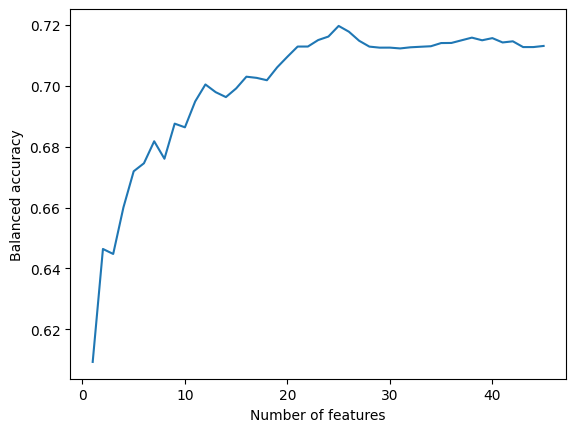

Fitting 5 folds for each of 45 candidates, totalling 225 fits


mutual_info_classif

{'select__k': 38}

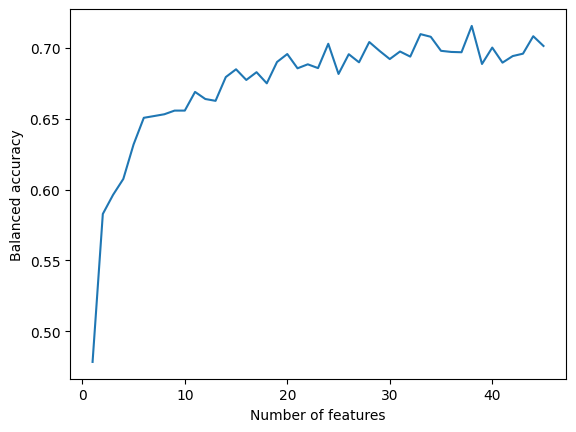

Fitting 5 folds for each of 45 candidates, totalling 225 fits


chi2

{'select__k': 45}

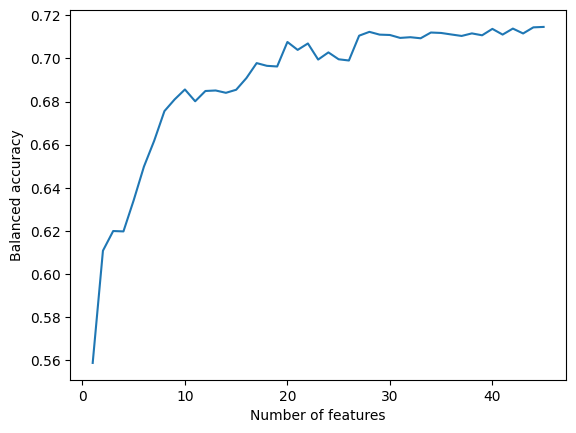

In [ ]:
# Importamos f_classif, mutual_info_classif y chi2.
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2

from sklearn.preprocessing import MinMaxScaler

# Importamos SelectKBest.
from sklearn.feature_selection import SelectKBest

def evaluar_modelos_seleccion_caracteristicas_LR(metrica):
    selector = SelectKBest(score_func=metrica)
    
    pipe_selector = Pipeline([
        ('scale', MinMaxScaler()),
        ('select', selector),
        ('model', LogisticRegression(random_state=13, class_weight='balanced'))
    ])

    param_grid = {"select__k": list(range(1, 46))}
    inner = StratifiedKFold(n_splits=5)
    tuneado = GridSearchCV(pipe_selector, param_grid, cv=inner, scoring='balanced_accuracy', n_jobs=-1, verbose=1)
    tuneado.fit(X_train, y_train)

    print(metrica.__name__)

    print(tuneado.best_params_)

    trained_pipeline = tuneado.best_estimator_

    import matplotlib.pyplot as plt
    plt.plot(tuneado.cv_results_['param_select__k'].data, tuneado.cv_results_['mean_test_score'])
    plt.ylabel('Balanced accuracy')
    plt.xlabel('Number of features')
    plt.show()

print('\n[bold yellow]Mejora de resultados LogisticRegression[/bold yellow]')

metricas = [f_classif, mutual_info_classif, chi2]

for metrica in metricas:
    evaluar_modelos_seleccion_caracteristicas_LR(metrica)

Ahora procederemos a sacar los 5 atributos más importantes y la precisión del modelo con los datos reducidos. Utilizaremos la métrica que menor número de atributos ha necesitado para llegar al pico.

In [ ]:
# Importamos f_classif, mutual_info_classif y chi2.
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2

from sklearn.preprocessing import MinMaxScaler

# Importamos SelectKBest.
from sklearn.feature_selection import SelectKBest

print('\n[bold yellow]Mejora de resultados LogisticRegression[/bold yellow]')

selector = SelectKBest(score_func=f_classif, k=25)
# Aplicamos el selector sobre los datos de entrenamiento y prueba.
X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)

# Obtener los puntajes de cada atributo.
scores = selector.scores_

# Crear una lista de tuplas que empareje cada nombre de atributo con su puntaje.
features_scores = list(zip(X_train.columns, scores))

# Ordenar la lista de mayor a menor según los puntajes.
features_scores = sorted(features_scores, key=lambda x: x[1], reverse=True)

# Imprimir los 5 atributos más importantes según metrica.
top_features = [feature[0] for feature in features_scores[:5]]
print("[green]Top 5 atributos más importantes:[/green]")
for feature in top_features:
    print(feature)

# Creamos un modelo de Regresión Logística y lo entrenamos con las características seleccionadas.
modelo = LogisticRegression(random_state=13, solver='liblinear', class_weight='balanced')

start = time.time()
modelo.fit(X_train_sel, y_train)
end = time.time()
tiempo_r = end - start

# Evaluamos el modelo con las características seleccionadas.
y_pred = modelo.predict(X_test_sel)
balanced_accuracy_r = balanced_accuracy_score(y_test, y_pred)
print(f"\n\nBalanced accuracy con las características seleccionadas: {balanced_accuracy:.4f}")
print(f'Tiempo de ejecución: {tiempo:.5f} segundos')

Mejora de resultados LogisticRegression

Top 5 atributos más importantes:

0

16

20

46

22

Balanced accuracy con las características seleccionadas: 0.7266

Tiempo de ejecución: 0.08630 segundos

Después de aplicar SelectKBest con distintas métricas de selección de características y entrenar un modelo de Regresión Logística, se obtuvo que las cinco características más importantes para predecir el resultado de la clasificación son 0, 16, 20, 46 y 22 (posteriormente se indicará a cuales equivalen en el dataframe original). Utilizando estas características seleccionadas, se obtuvo un valor de balanced accuracy de 0.7274. El tiempo de ejecución del modelo con estas características fue de 0.04727 segundos.

In [ ]:
#ratio de tiempo de entrenamiento
print(f'\nRatio Tiempo de entrenamiento sin reducir / reducido: {tiempo / tiempo_r:.4f}')

#rattio de balanced accuracy
print(f'\nRatio Balanced accuracy reducido / sin reducir: {balanced_accuracy_r / balanced_accuracy:.4f}')

Ratio Tiempo de entrenamiento sin reducir / reducido: 2.6137

Ratio Balanced accuracy reducido / sin reducir: 1.0011

En este caso, se observa que la reducción de características no tiene un impacto significativo en la precisión del modelo, ya que el ratio de balanced accuracy reducido/sin reducir es de 1. Esto significa que el modelo sigue teniendo la misma precisión con un conjunto reducido de características. Sin embargo, se observa que la reducción de características lleva a una disminución en el tiempo de entrenamiento, ya que el ratio de tiempo de entrenamiento sin reducir/reducido es de 2.6137, lo que indica que el modelo reducido se entrena más rápido que el modelo sin reducción de características.

## **Boosting**

Mejora de resultados LogisticRegression

Fitting 5 folds for each of 46 candidates, totalling 230 fits
Fitting 5 folds for each of 46 candidates, totalling 230 fits
Fitting 5 folds for each of 46 candidates, totalling 230 fits


AdaBoostClassifier

Mejor métrica: f_classif

Numero de atributos seleccionados: 29

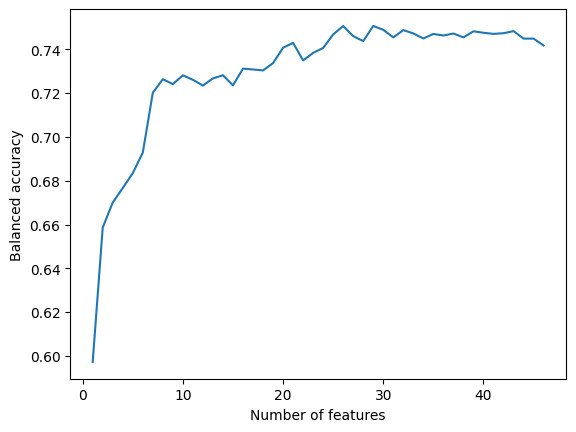

Fitting 5 folds for each of 46 candidates, totalling 230 fits
Fitting 5 folds for each of 46 candidates, totalling 230 fits
Fitting 5 folds for each of 46 candidates, totalling 230 fits


GradientBoostingClassifier

Mejor métrica: f_classif

Numero de atributos seleccionados: 46

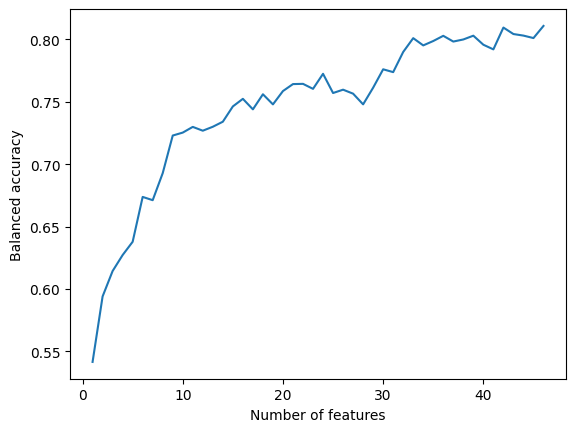

Fitting 5 folds for each of 46 candidates, totalling 230 fits
Fitting 5 folds for each of 46 candidates, totalling 230 fits
Fitting 5 folds for each of 46 candidates, totalling 230 fits


XGBClassifier

Mejor métrica: mutual_info_classif

Numero de atributos seleccionados: 40

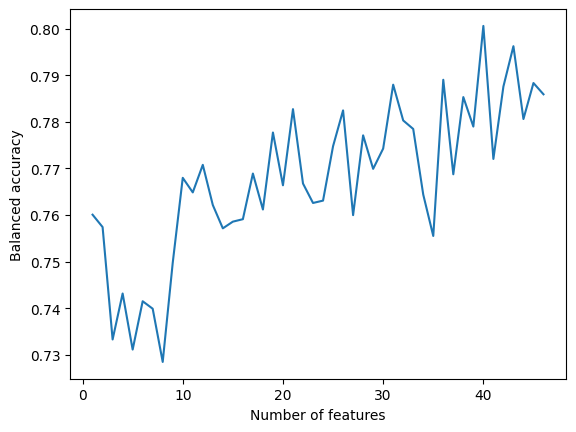

Fitting 5 folds for each of 46 candidates, totalling 230 fits
Fitting 5 folds for each of 46 candidates, totalling 230 fits
Fitting 5 folds for each of 46 candidates, totalling 230 fits


LGBMClassifier

Mejor métrica: mutual_info_classif

Numero de atributos seleccionados: 32

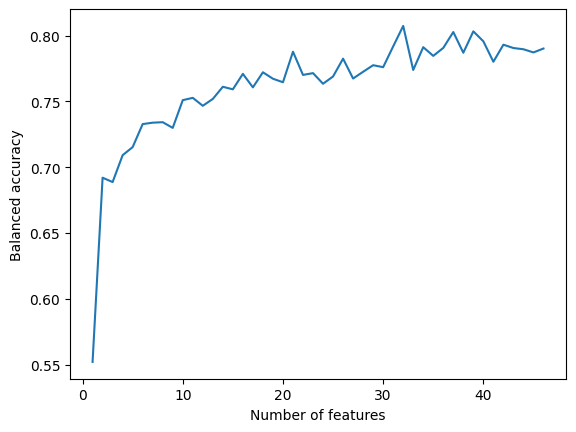

In [ ]:
def evaluar_modelos_seleccion_caracteristicas(modelo, metricas):

    metrica_seleccionada = "f_classif"
    k = 47
    tuneado_seleccion = None
        
    for metrica in metricas:
        selector = SelectKBest(score_func=metrica)
        
        pipe_selector = Pipeline([
            ('scale', MinMaxScaler()),
            ('select', selector),
            ('model', modelo)
        ])

        param_grid = {"select__k": list(range(1, 47))}
        inner = StratifiedKFold(n_splits=5)
        tuneado = GridSearchCV(pipe_selector, param_grid, cv=inner, scoring='balanced_accuracy', n_jobs=-1, verbose=1)
        if modelo.__class__.__name__ == "AdaBoostClassifier":
            tuneado.fit(X_train, y_train, model__sample_weight=sample_weights)
        elif modelo.__class__.__name__ == "GradientBoostingClassifier":
            tuneado.fit(X_train, y_train, model__sample_weight=weights)
        else:
            tuneado.fit(X_train, y_train)

        if tuneado.best_params_['select__k'] < k:
            k = tuneado.best_params_['select__k']
            metrica_seleccionada = metrica.__name__
            tuneado_seleccion = tuneado

    print(modelo.__class__.__name__)
    print(f"Mejor métrica: {metrica_seleccionada}")
    print(f"Numero de atributos seleccionados: {k}")

    import matplotlib.pyplot as plt
    plt.plot(tuneado_seleccion.cv_results_['param_select__k'].data, tuneado_seleccion.cv_results_['mean_test_score'])
    plt.ylabel('Balanced accuracy')
    plt.xlabel('Number of features')
    plt.show()

print('\n[bold yellow]Mejora de resultados LogisticRegression[/bold yellow]')

metricas = [f_classif, mutual_info_classif, chi2]

for modelo in modelos_ajustados:
    evaluar_modelos_seleccion_caracteristicas(modelo, metricas)


Ahora procederemos a sacar los 5 atributos más importantes y la precisión del modelo con los datos reducidos (para cada modelo). Utilizaremos la métrica que menor número de atributos ha necesitado para llegar al pico. Para Gradieent Boosting seleccionamos 40, ya que esta cerca del pico y eliminamos 6 atributos.

In [ ]:
class_counts = np.bincount(y_train)
sample_weights = np.zeros(len(y_train))
for i, count in enumerate(class_counts):
    sample_weights[y_train == i] = class_counts.sum() / (len(class_counts) * count)

def atributos_mas_importantes_boosting(modelo, metrica, k):
    selector = SelectKBest(score_func=metrica, k=k)

    # Aplicar el selector sobre los datos de entrenamiento y prueba.
    X_train_sel = selector.fit_transform(X_train, y_train)
    X_test_sel = selector.transform(X_test)

    # Crear y entrenar un modelo con las características seleccionadas.
    if modelo.__class__.__name__ == "AdaBoostClassifier":
        modelo.fit(X_train_sel, y_train, sample_weight=sample_weights)
    elif modelo.__class__.__name__ == "GradientBoostingClassifier":
        modelo.fit(X_train_sel, y_train, sample_weight=weights)
    else:
        modelo.fit(X_train_sel, y_train)

    # Evaluar el modelo con las características seleccionadas.
    score = modelo.score(X_test_sel, y_test)

    # Obtener los puntajes de importancia de características y ordenarlos de mayor a menor.
    scores = selector.scores_
    feature_scores = list(zip(X_train.columns, scores))
    feature_scores = sorted(feature_scores, key=lambda x: x[1], reverse=True)

    if modelo.__class__.__name__ == "AdaBoostClassifier":
        start = time.time()
        modelo.fit(X_train_sel, y_train, sample_weight=sample_weights)
        end = time.time()
    elif modelo.__class__.__name__ == "GradientBoostingClassifier":
        start = time.time()
        modelo.fit(X_train_sel, y_train, sample_weight=weights)
        end = time.time()
    else:
        start = time.time()
        modelo.fit(X_train_sel, y_train)
        end = time.time()
   
    tiempo = end - start

    print(modelo.__class__.__name__)

    # Evaluar el modelo con las características seleccionadas.
    y_pred = modelo.predict(X_test_sel)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print(f"\n\nBalanced accuracy con las características seleccionadas: {balanced_accuracy:.4f}")
    print(f'Tiempo de ejecución: {tiempo:.5f} segundos')

    # Imprimir los 5 atributos más importantes según f_classif.
    top_features = [feature[0] for feature in feature_scores[:5]]
    print(f"[green]Top 5 atributos más importantes para {modelo.__class__.__name__ }:[/green]")
    for feature in top_features:
      print(feature)

    print()
    
    return balanced_accuracy, tiempo


In [ ]:
ada = atributos_mas_importantes_boosting(AdaBoostClassifier(random_state=13, learning_rate=0.5, n_estimators=200), f_classif, 29)
gb = atributos_mas_importantes_boosting(GradientBoostingClassifier(random_state=13, learning_rate=0.5, max_depth=5, n_estimators=200), f_classif, 40)
xgb = atributos_mas_importantes_boosting(XGBClassifier(random_state=13, scale_pos_weight=proporcion),  mutual_info_classif, 40)
lgbm = atributos_mas_importantes_boosting(LGBMClassifier(random_state=13, learning_rate=0.1, max_depth=7, n_estimators=200, class_weight='balanced'),  mutual_info_classif, 32)


AdaBoostClassifier

Balanced accuracy con las características seleccionadas: 0.7439

Tiempo de ejecución: 0.91186 segundos

Top 5 atributos más importantes para AdaBoostClassifier:

0

16

20

46

22

GradientBoostingClassifier

Balanced accuracy con las características seleccionadas: 0.8918

Tiempo de ejecución: 3.01854 segundos

Top 5 atributos más importantes para GradientBoostingClassifier:

0

16

20

46

22

XGBClassifier

Balanced accuracy con las características seleccionadas: 0.8948

Tiempo de ejecución: 0.77094 segundos

Top 5 atributos más importantes para XGBClassifier:

12

0

18

16

7

LGBMClassifier

Balanced accuracy con las características seleccionadas: 0.9013

Tiempo de ejecución: 0.21613 segundos

Top 5 atributos más importantes para LGBMClassifier:

12

7

0

20

18


Los atributos más repetidos en los top 5 son 0 y 16, ya que aparecen en el top 5 de tres de los cuatro modelos (AdaBoostClassifier, GradientBoostingClassifier y XGBClassifier). Además, el atributo 12 aparece en el top 5 de dos de los cuatro modelos (XGBClassifier y LGBMClassifier), así como el 18. Al 22, 20 y 46 les ocurre lo mismo, aparecen dos veces (AdaBoostClassifier, GradientBoostingClassifier). Estos nos deja que los atributos más importantes son el 0, 16 20, 22 y 46, ya que también forman parte del top 5 de Logistic Regression. Estos atributos son equivalentes a:
- 0:  hrs (Número de horas trabajadas)
- 16: EducationField_Human Resources
- 20: EducationField_Other
- 22: Gender_Female
- 46: YearsWithCurrManager

In [ ]:
#calculamos cuanto tardamos en entrenar los modelos con los mejores hiperparametros
start= time.time()
modelo = modelos_ajustados[0]
modelo.fit(X_train, y_train, sample_weight=sample_weights)
end = time.time()
tiempo_ada_ajustado = end - start

start= time.time()
modelo = modelos_ajustados[1]
modelo.fit(X_train, y_train, sample_weight=weights)
end = time.time()
tiempo_gb_ajustado = end - start

start= time.time()
modelo = modelos_ajustados[2]
modelo.fit(X_train, y_train)
end = time.time()
tiempo_xgb_ajustado = end - start

start= time.time()
modelo = modelos_ajustados[3]
modelo.fit(X_train, y_train)
end = time.time()
tiempo_lgbm_ajustado = end - start


#ratios de precision y tiempo sin y reducido
print("\n\n[bold yellow]Ratios de precision y tiempo sin reducir y reducido[/bold yellow]")

print('\n[bold red]AdaBoostClassifier [/bold red]')
#ratio
print(f"Ratio tiempo sin reducir / reducido: {tiempo_ada_ajustado/ada[1]:.4f}")
print(f"Ratio balance accuracy sin reducir / reducido: {resultados_ajuste['AdaBoost']['balanced_accuracy']/ada[0]:.4f}")

print("\n[bold red]GradientBoostingClassifier[/bold red]")
#ratio
print(f"Ratio tiempo sin reducir / reducido: {tiempo_gb_ajustado/gb[1]:.4f}")
print(f"Ratio balance accuracy sin reducir / reducido:: {resultados_ajuste['Gradient Boosting']['balanced_accuracy']/gb[0]:.4f}")

print("\n[bold red]XGBClassifier[/bold red]")
#ratio
print(f"Ratio tiempo sin reducir / reducido: {tiempo_xgb_ajustado/xgb[1]:.4f}")
print(f"Ratio balance accuracy sin reducir / reducido:: {resultados_ajuste['XGBoost']['balanced_accuracy']/xgb[0]:.4f}")

print("\n[bold red]LGBMClassifier[/bold red]")
#ratio
print(f"Ratio tiempo sin reducir / reducido: {tiempo_lgbm_ajustado/lgbm[1]:.4f}")
print(f"Ratio balance accuracy sin reducir / reducido:: {resultados_ajuste['LightGBM']['balanced_accuracy']/lgbm[0]:.4f}")


Ratios de precision y tiempo sin reducir y reducido

AdaBoostClassifier 

Ratio tiempo sin reducir / reducido: 1.3302

Ratio balance accuracy sin reducir / reducido: 1.0084

GradientBoostingClassifier

Ratio tiempo sin reducir / reducido: 1.5395

Ratio balance accuracy sin reducir / reducido:: 1.0150

XGBClassifier

Ratio tiempo sin reducir / reducido: 1.2720

Ratio balance accuracy sin reducir / reducido:: 0.9776

LGBMClassifier

Ratio tiempo sin reducir / reducido: 1.1730

Ratio balance accuracy sin reducir / reducido:: 0.9794

Podemos observar que el tiempo mejora en todos los casos al usar menos atributos, aunque por el entorno en el que lo estamos ejecutando los ratios podrían ser variables. Hemos observado que mejoramos la precisión de los modelos XGBClassifier y LGBMClassifier entre un 2-3%. Para el resto de métodos no la empeoramos y mejoramos el rendimiento al requerir menos argumentos.

# **Creación del modelo final**

In [ ]:
weights = np.where(y_train == 0, 1 / np.sum(y_train == 0), 1 / np.sum(y_train == 1))

# Entrenamiento del modelo
model = GradientBoostingClassifier(random_state=13, learning_rate=0.5, max_depth=5, n_estimators=200)
model.fit(X_train, y_train, sample_weight=weights)

# Guardar modelo
filename = 'modelo_final.pkl'
pickle.dump(modelo, open(filename, 'wb'))


# **Conclusión final**

En este trabajo hemos realizado un análisis exhaustivo de un conjunto de datos de recursos humanos, con el objetivo de extraer información relevante que pueda ser utilizada para la toma de decisiones en una empresa. A lo largo del proceso, hemos aplicado técnicas de limpieza, transformación y visualización de datos, lo que nos ha permitido comprender mejor la estructura y las características del conjunto de datos. Además, hemos utilizado técnicas de modelado y aprendizaje automático para predecir la posibilidad de abandono de los empleados, obteniendo un modelo con una precisión de más del 90% (Gradient Boosting Ajustado con todos los atributos). 

Entre las principales enseñanzas de este trabajo, se destaca la importancia de la exploración y la limpieza de los datos, ya que un conjunto de datos mal estructurado puede afectar significativamente la calidad de los resultados obtenidos. También es importante seleccionar cuidadosamente las variables a incluir en un modelo de aprendizaje automático, ya que incluir variables irrelevantes o altamente correlacionadas puede reducir su precisión. Finalmente, es esencial evaluar la precisión de los modelos obtenidos y compararlos con modelos más simples para determinar si realmente están proporcionando una mejora significativa en la predicción de los datos. 

En conclusión, este trabajo ha demostrado la importancia de utilizar técnicas de análisis de datos y aprendizaje automático para mejorar la toma de decisiones empresariales. Al aplicar estas técnicas a un conjunto de datos de recursos humanos, hemos obtenido información valiosa sobre las características que pueden influir en la rotación de los empleados, lo que puede ser utilizado para desarrollar políticas de retención de personal y mejorar la eficiencia de la empresa.

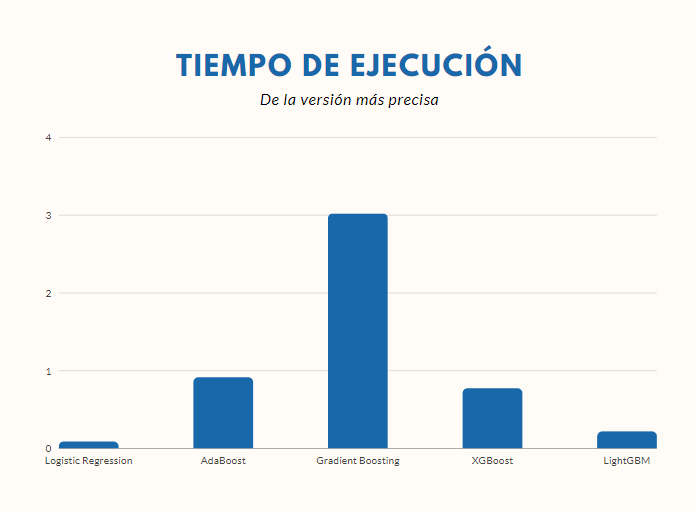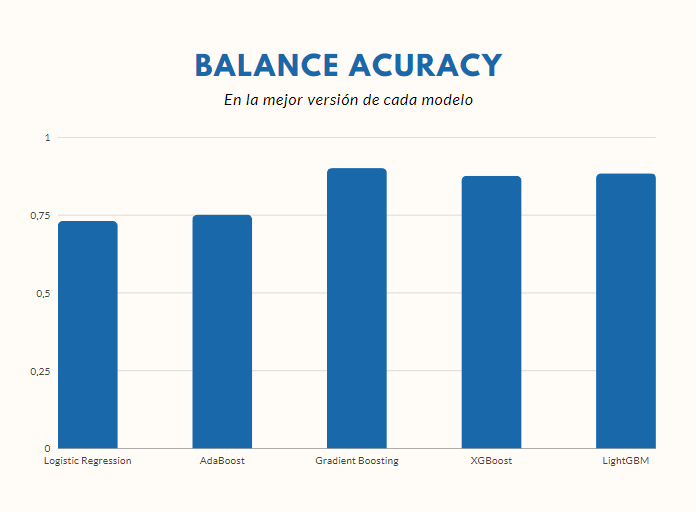